## Upload Dataset

In [36]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
file_name = next(iter(uploaded))

Saving data - data (6).csv to data - data (6) (1).csv


## Convert csv to dataframe

In [37]:
df = pd.read_csv(file_name)

## Inspect Q6 column of dataframe

In [38]:
print(df['Q6'].nunique())
print(df['Q6'].unique())

5
['The symptoms of burnout that I’m experiencing won’t go away. I think about frustration at work a lot'
 'I am definitely burning out and have one or more symptoms of burnout, such as physical and emotional exhaustion'
 'Occasionally I am under stress, and I don’t always have as much energy as I once did, but I don’t feel burned out'
 'I feel completely burned out and often wonder if I can go on. I am at the point where I may need some changes or may need to seek some sort of help'
 'I enjoy my work. I have no symptoms of burnout' nan]


## Encode burnout labels from Q6 column, store in Q6_encoded column

In [39]:
q6_mapping = {
    "I enjoy my work. I have no symptoms of burnout": 0,
    "Occasionally I am under stress, and I don’t always have as much energy as I once did, but I don’t feel burned out": 1,
    "I am definitely burning out and have one or more symptoms of burnout, such as physical and emotional exhaustion": 2,
    "The symptoms of burnout that I’m experiencing won’t go away. I think about frustration at work a lot": 3,
    "I feel completely burned out and often wonder if I can go on. I am at the point where I may need some changes or may need to seek some sort of help": 4
}
df["Q6_encoded"] = df["Q6"].map(q6_mapping)

## Encode all other categorial columns and convert them to numerical

In [40]:
freq_mapping = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Often": 3,
    "Always": 4
}
for col in ["Q1", "Q2", "Q3", "Q4", "Q5"]:
    df[col] = df[col].map(freq_mapping)

print(df[["Q1", "Q2", "Q3", "Q4", "Q5"]])


      Q1   Q2   Q3   Q4   Q5
0    0.0  0.0  0.0  0.0  0.0
1    3.0  1.0  1.0  1.0  1.0
2    2.0  3.0  3.0  2.0  1.0
3    2.0  3.0  3.0  2.0  1.0
4    2.0  4.0  2.0  4.0  2.0
..   ...  ...  ...  ...  ...
323  3.0  3.0  2.0  3.0  2.0
324  3.0  3.0  2.0  3.0  2.0
325  3.0  3.0  2.0  3.0  2.0
326  3.0  3.0  2.0  3.0  2.0
327  3.0  3.0  2.0  3.0  2.0

[328 rows x 5 columns]


## Check Class Distribution

In [41]:
print("Samples per class in Q6_encoded:")
print(df['Q6_encoded'].value_counts().sort_index())

print(f"\nTotal NaN values: {df['Q6_encoded'].isna().sum()}")

Samples per class in Q6_encoded:
Q6_encoded
0.0    67
1.0    88
2.0    64
3.0    54
4.0    53
Name: count, dtype: int64

Total NaN values: 2


## Undersample class 1.0

In [42]:
import pandas as pd
import numpy as np

print("\nRemoving 20 random elements where Q6_encoded is 0.0...")

filtered_df = df[df['Q6_encoded'] == 1.0]
num_to_remove = 20
if len(filtered_df) < num_to_remove:
    print(f"Warning: Not enough samples (found {len(filtered_df)}) to remove {num_to_remove} rows.")
    indices_to_remove = filtered_df.index
else:
    indices_to_remove = filtered_df.sample(n=num_to_remove, random_state=42).index
df_cleaned = df.drop(indices_to_remove)

print(f"Number of elements removed: {len(indices_to_remove)}")
print(f"DataFrame shape after removal: {df_cleaned.shape}")
print("\nVerifying removed elements are gone:")
print(f"Do removed indices still exist in the new DataFrame? {any(idx in df_cleaned.index for idx in indices_to_remove)}")
df=df_cleaned


Removing 20 random elements where Q6_encoded is 0.0...
Number of elements removed: 20
DataFrame shape after removal: (308, 41)

Verifying removed elements are gone:
Do removed indices still exist in the new DataFrame? False


## Inspect number of samples per class

In [43]:
print("Samples per class in Q6_encoded:")
print(df['Q6_encoded'].value_counts().sort_index())
print(f"\nTotal NaN values: {df['Q6_encoded'].isna().sum()}")

Samples per class in Q6_encoded:
Q6_encoded
0.0    67
1.0    68
2.0    64
3.0    54
4.0    53
Name: count, dtype: int64

Total NaN values: 2


## Remove all unnecessary columns

In [44]:
selected_columns = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6_encoded", "Avg_EAR", "Std_EAR", "Avg_MAR", "Std_MAR", "Positive_Percent", "Neutral_Percent", "Negative_Percent", "Sentiment_Pos", "Sentiment_Neu", "Sentiment_Neg", "Sentiment_Comp"]

df = df[selected_columns]

## Drop rows with missing values

In [45]:
df=df.dropna()

## Observe remaining class distribution

In [46]:
print("Samples per class in Q6_encoded:")
print(df['Q6_encoded'].value_counts().sort_index())

print(f"\nTotal NaN values: {df['Q6_encoded'].isna().sum()}")

Samples per class in Q6_encoded:
Q6_encoded
0.0    67
1.0    67
2.0    60
3.0    54
4.0    52
Name: count, dtype: int64

Total NaN values: 0


## Divide Sentiment_Comp into 5 bins, then compare these bin values to the label values and delete all the samples where bins!=label

In [47]:
import pandas as pd
import numpy as np
df1=df

df1['label'] = pd.qcut(df1['Sentiment_Comp'], q=5, labels=False, retbins=False)
df1['label'] = 4 - df1['label']

bins = np.linspace(-1.0, 1.0, num=6)
labels = [4.0, 3.0, 2.0, 1.0, 0.0]
df1['q6_encoded'] = pd.cut(df1['Sentiment_Comp'], bins=bins, labels=labels, include_lowest=True, right=False)

comparison_result = df1['label'] == df1['q6_encoded']
true_count = comparison_result.sum()
false_count = len(df1) - true_count

print(f"Number of rows where the comparison was TRUE: {true_count}")
print(f"Number of rows where the comparison was FALSE: {false_count}")

# Compare the two columns and get a boolean series
comparison_result = df1['label'] == df1['q6_encoded']
true_count = comparison_result.sum()
false_count = len(df1) - true_count

print(f"Number of rows before dropping: {len(df1)}")
print(f"Number of rows where the comparison was TRUE: {true_count}")
print(f"Number of rows where the comparison was FALSE: {false_count}")

df1 = df1[comparison_result].copy()

print(f"Number of rows after dropping: {len(df1)}")

df=df1

Number of rows where the comparison was TRUE: 266
Number of rows where the comparison was FALSE: 34
Number of rows before dropping: 300
Number of rows where the comparison was TRUE: 266
Number of rows where the comparison was FALSE: 34
Number of rows after dropping: 266


## Check Sample distribution

In [48]:
print("Samples per class in Q6_encoded:")
print(df['Q6_encoded'].value_counts().sort_index())

print(f"\nTotal NaN values: {df['Q6_encoded'].isna().sum()}")

Samples per class in Q6_encoded:
Q6_encoded
0.0    63
1.0    61
2.0    52
3.0    47
4.0    43
Name: count, dtype: int64

Total NaN values: 0


## Drop label column and perfrom train-test-split

In [49]:
from sklearn.model_selection import train_test_split
# --- Features & target ---
X = df.drop(columns=["Q6_encoded"])
y = df["Q6_encoded"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Collect all columns to be used for prediction

In [50]:
numerical_features = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Avg_EAR', 'Std_EAR', 'Avg_MAR', 'Std_MAR', 'Positive_Percent', 'Neutral_Percent', 'Negative_Percent', 'Sentiment_Pos', 'Sentiment_Neu', 'Sentiment_Neg', 'Sentiment_Comp']
print("Numerical features being scaled:", numerical_features)

Numerical features being scaled: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Avg_EAR', 'Std_EAR', 'Avg_MAR', 'Std_MAR', 'Positive_Percent', 'Neutral_Percent', 'Negative_Percent', 'Sentiment_Pos', 'Sentiment_Neu', 'Sentiment_Neg', 'Sentiment_Comp']


## Scale all features and make all class distributions using SMOTE

In [51]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Scale only the training data and transform both train and test
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]),
                             columns=numerical_features, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_features]),
                            columns=numerical_features, index=X_test.index)

# 4. Then apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

## Display class distribution before and after SMOTE

In [52]:
# After train-test split
print("\n=== AFTER TRAIN-TEST SPLIT ===")
print("Training set class distribution:")
print(y_train.value_counts().sort_index())
print("Test set class distribution:")
print(y_test.value_counts().sort_index())

# After SMOTE
print("\n=== AFTER SMOTE ===")
print("Resampled training set class distribution:")
print(y_train_resampled.value_counts().sort_index())
print(f"Resampled training samples: {len(y_train_resampled)}")



=== AFTER TRAIN-TEST SPLIT ===
Training set class distribution:
Q6_encoded
0.0    50
1.0    49
2.0    41
3.0    38
4.0    34
Name: count, dtype: int64
Test set class distribution:
Q6_encoded
0.0    13
1.0    12
2.0    11
3.0     9
4.0     9
Name: count, dtype: int64

=== AFTER SMOTE ===
Resampled training set class distribution:
Q6_encoded
0.0    50
1.0    50
2.0    50
3.0    50
4.0    50
Name: count, dtype: int64
Resampled training samples: 250


## Logistic regression

Classification Report:

Classes in predictions: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]
              precision    recall  f1-score   support

   Class 0.0       0.71      0.77      0.74        13
   Class 1.0       0.54      0.58      0.56        12
   Class 2.0       0.33      0.27      0.30        11
   Class 3.0       0.56      0.56      0.56         9
   Class 4.0       0.44      0.44      0.44         9

    accuracy                           0.54        54
   macro avg       0.52      0.53      0.52        54
weighted avg       0.53      0.54      0.53        54



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


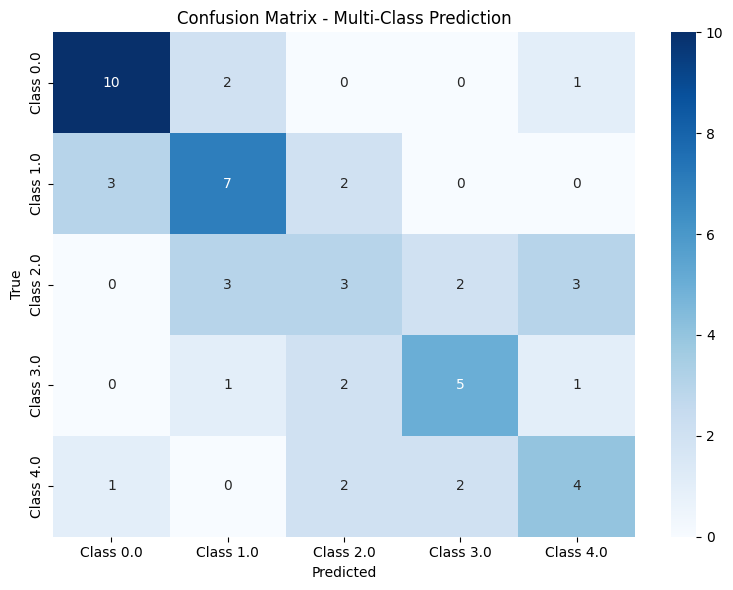

[[10  2  0  0  1]
 [ 3  7  2  0  0]
 [ 0  3  3  2  3]
 [ 0  1  2  5  1]
 [ 1  0  2  2  4]]

Class distribution in test set:
Q6_encoded
0.0    13
1.0    12
2.0    11
3.0     9
4.0     9
Name: count, dtype: int64


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Train model ---
model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
model.fit(X_train_resampled, y_train_resampled)  # Changed to resampled data

# --- Predict on test set ---
y_pred = model.predict(X_test_scaled)  # Changed to scaled test data

# --- Evaluation ---
print("Classification Report:\n")

# Get the actual classes that were predicted
actual_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes in predictions: {actual_classes}")

# Create target names only for existing classes
target_names = [f"Class {i}" for i in actual_classes]

print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Multi-Class Prediction")
plt.tight_layout()
plt.show()
print(cm)

# Additional: Show class distribution for reference
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts().sort_index())

## Random Forest Classifier

Training Random Forest model...

RANDOM FOREST CLASSIFICATION REPORT
Classes in predictions: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]
              precision    recall  f1-score   support

   Class 0.0       0.77      0.77      0.77        13
   Class 1.0       0.58      0.58      0.58        12
   Class 2.0       0.64      0.64      0.64        11
   Class 3.0       0.88      0.78      0.82         9
   Class 4.0       0.60      0.67      0.63         9

    accuracy                           0.69        54
   macro avg       0.69      0.69      0.69        54
weighted avg       0.69      0.69      0.69        54



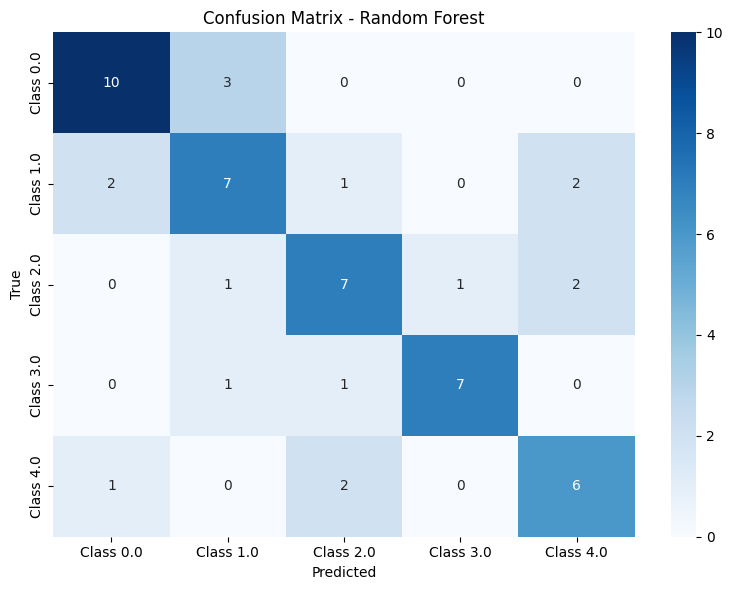

Confusion Matrix:
[[10  3  0  0  0]
 [ 2  7  1  0  2]
 [ 0  1  7  1  2]
 [ 0  1  1  7  0]
 [ 1  0  2  0  6]]


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Train Random Forest model ---
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

# --- Predict on test set ---
y_pred_rf = rf_model.predict(X_test_scaled)

# --- Evaluation ---
print("\n" + "="*50)
print("RANDOM FOREST CLASSIFICATION REPORT")
print("="*50)

# Get the actual classes that were predicted
actual_classes = sorted(np.unique(np.concatenate([y_test, y_pred_rf])))
print(f"Classes in predictions: {actual_classes}")

# Create target names only for existing classes
target_names = [f"Class {i}" for i in actual_classes]

print(classification_report(y_test, y_pred_rf, target_names=target_names, zero_division=0))

# --- Confusion matrix ---
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm_rf)

## XGBoost

Training XGBoost model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:32:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBOOST CLASSIFICATION REPORT
Classes in predictions: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]
              precision    recall  f1-score   support

   Class 0.0       0.71      0.77      0.74        13
   Class 1.0       0.55      0.50      0.52        12
   Class 2.0       0.58      0.64      0.61        11
   Class 3.0       0.70      0.78      0.74         9
   Class 4.0       0.86      0.67      0.75         9

    accuracy                           0.67        54
   macro avg       0.68      0.67      0.67        54
weighted avg       0.67      0.67      0.67        54



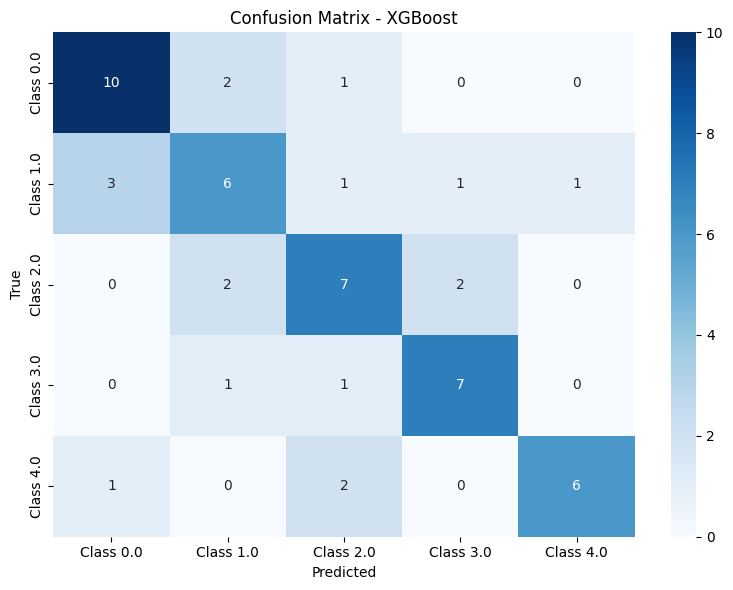

Confusion Matrix:
[[10  2  1  0  0]
 [ 3  6  1  1  1]
 [ 0  2  7  2  0]
 [ 0  1  1  7  0]
 [ 1  0  2  0  6]]


In [55]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Train XGBoost model ---
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss'  # for multi-class classification
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# --- Predict on test set ---
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- Evaluation ---
print("\n" + "="*50)
print("XGBOOST CLASSIFICATION REPORT")
print("="*50)

# Get the actual classes that were predicted
actual_classes = sorted(np.unique(np.concatenate([y_test, y_pred_xgb])))
print(f"Classes in predictions: {actual_classes}")

# Create target names only for existing classes
target_names = [f"Class {i}" for i in actual_classes]

print(classification_report(y_test, y_pred_xgb, target_names=target_names, zero_division=0))

# --- Confusion matrix ---
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm_xgb)


## Lightgbm

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 250, number of used features: 16
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

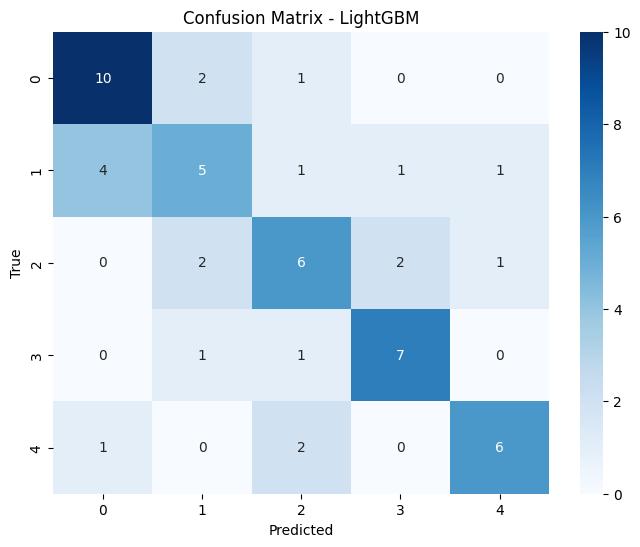

Accuracy: 0.6296


In [56]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train LightGBM model
print("Training LightGBM model...")
lgbm_model = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    class_weight='balanced'
)
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Evaluation
print("\n" + "="*50)
print("LIGHTGBM CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_lgbm, zero_division=0))

# Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")

## SVM

Training SVM model...

SVM CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75        13
         1.0       0.53      0.67      0.59        12
         2.0       0.75      0.82      0.78        11
         3.0       0.88      0.78      0.82         9
         4.0       0.75      0.67      0.71         9

    accuracy                           0.72        54
   macro avg       0.75      0.72      0.73        54
weighted avg       0.74      0.72      0.73        54



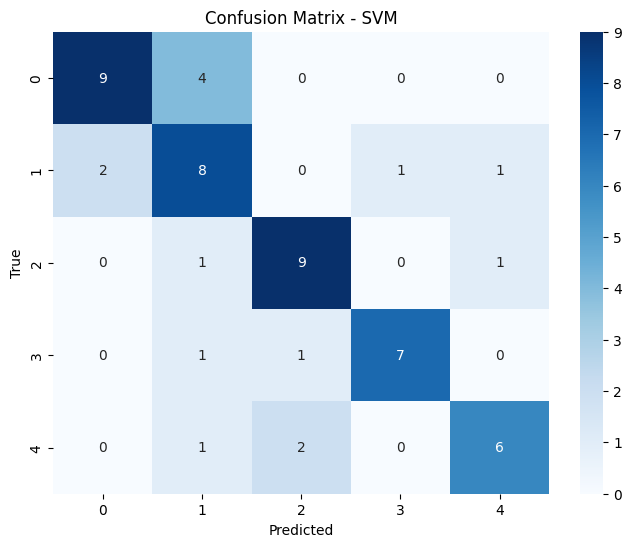

Accuracy: 0.7222


In [57]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train SVM model
print("Training SVM model...")
svm_model = SVC(
    random_state=42,
    kernel='rbf',
    class_weight='balanced',
    probability=True
)
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print("\n" + "="*50)
print("SVM CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")

## install catboost

In [58]:
!pip install catboost

## CatBoost

Training CatBoost model...

PLOTTING LOSS GRAPH


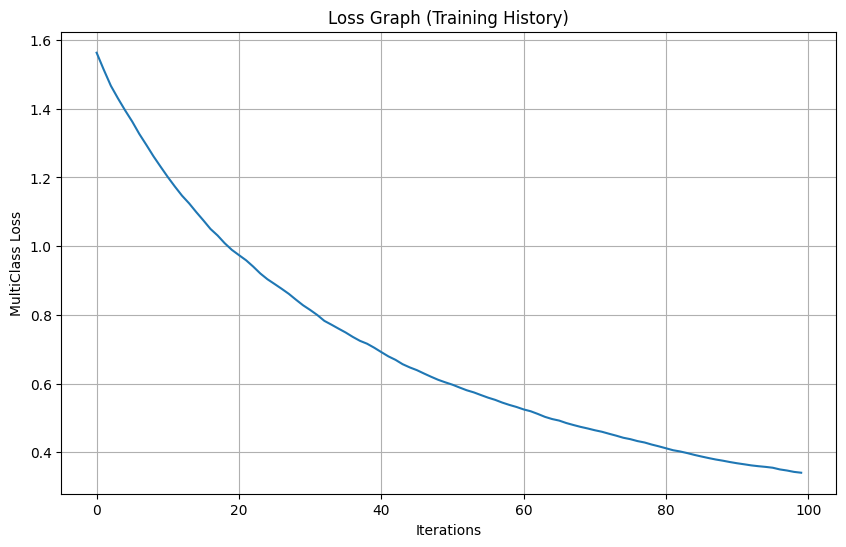


PLOTTING ROC CURVE


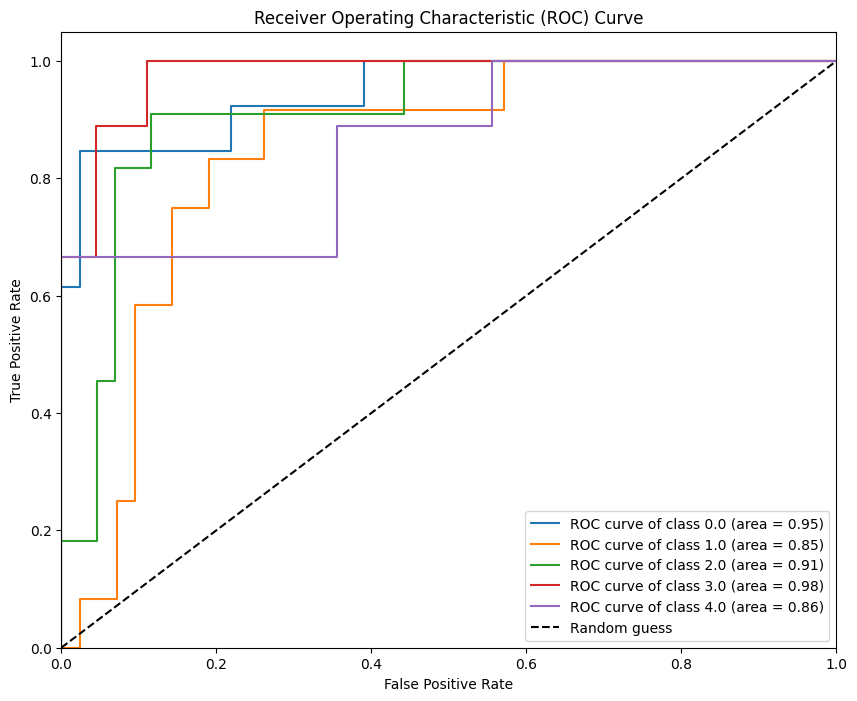


CATBOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        13
         1.0       0.69      0.75      0.72        12
         2.0       0.73      0.73      0.73        11
         3.0       0.80      0.89      0.84         9
         4.0       0.86      0.67      0.75         9

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54



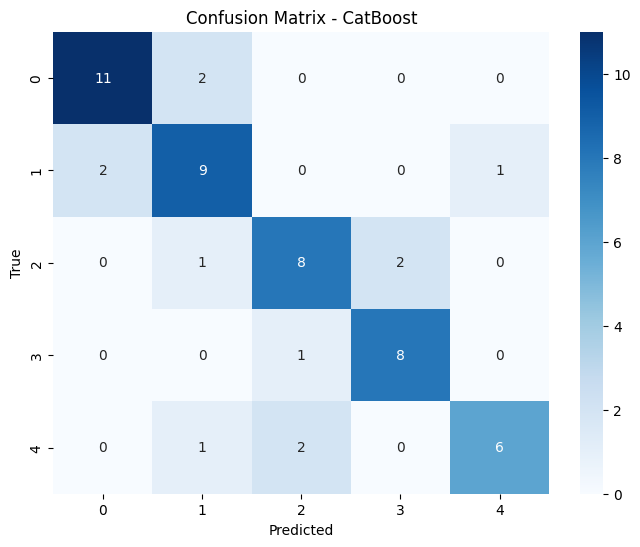

Accuracy: 0.7778

CONFUSION ANALYSIS
Class 0: 0.846 (11/13)
  → Misclassified as Class 1: 2 samples
Class 1: 0.750 (9/12)
  → Misclassified as Class 0: 2 samples
  → Misclassified as Class 4: 1 samples
Class 2: 0.727 (8/11)
  → Misclassified as Class 1: 1 samples
  → Misclassified as Class 3: 2 samples
Class 3: 0.889 (8/9)
  → Misclassified as Class 2: 1 samples
Class 4: 0.667 (6/9)
  → Misclassified as Class 1: 1 samples
  → Misclassified as Class 2: 2 samples


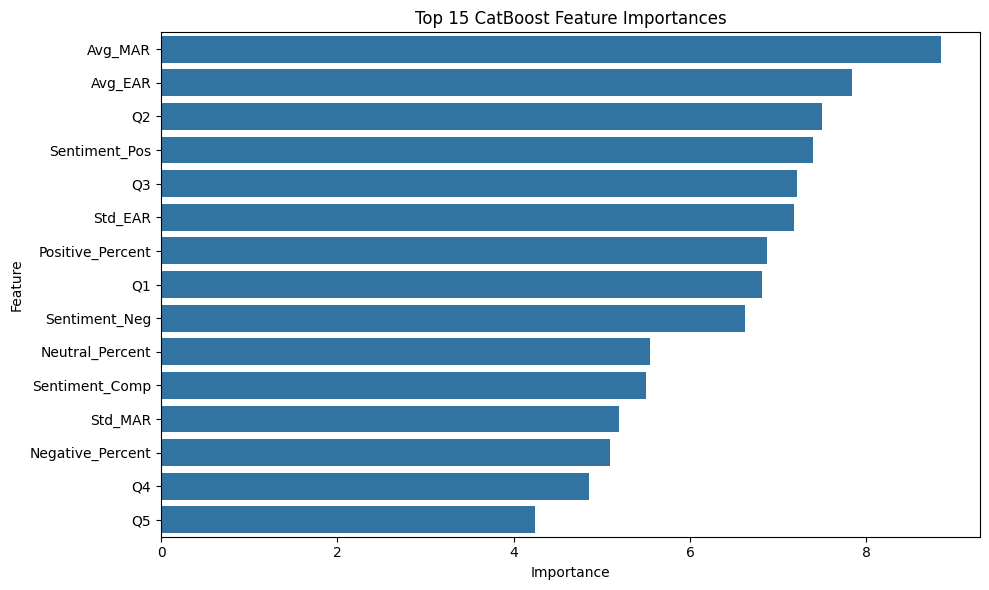

[[10  2  0  0  1]
 [ 3  7  2  0  0]
 [ 0  3  3  2  3]
 [ 0  1  2  5  1]
 [ 1  0  2  2  4]]


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Train CatBoost model
print("Training CatBoost model...")
catboost_model = CatBoostClassifier(
    random_state=42,
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    early_stopping_rounds=50 # Added for efficiency
)
# Note: To plot the loss graph, we need to provide eval_set
catboost_model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test_scaled, y_test))

# Predict
y_pred_catboost = catboost_model.predict(X_test_scaled)
# Get predicted probabilities for ROC curve
y_pred_proba = catboost_model.predict_proba(X_test_scaled)

# ==============================================================================
# Part 1: Plotting the Loss Graph
# ==============================================================================
print("\n" + "="*50)
print("PLOTTING LOSS GRAPH")
print("="*50)
loss_history = catboost_model.get_evals_result()['learn']['MultiClass']
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Loss Graph (Training History)')
plt.xlabel('Iterations')
plt.ylabel('MultiClass Loss')
plt.grid(True)
plt.show()

# ==============================================================================
# Part 2: Plotting the ROC Curve
# ==============================================================================
print("\n" + "="*50)
print("PLOTTING ROC CURVE")
print("="*50)

# Binarize the true labels for a multi-class ROC curve
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ==============================================================================
# Part 3: Evaluation & Confusion Analysis
# ==============================================================================
print("\n" + "="*50)
print("CATBOOST CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_catboost, zero_division=0))

cm_catboost = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CatBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred_catboost):.4f}")
print("\n" + "="*50)
print("CONFUSION ANALYSIS")
print("="*50)

classes = np.unique(y_test)
for i in range(len(classes)):
    true_class = classes[i]
    total_true = cm_catboost[i].sum()
    correct_predictions = cm_catboost[i, i]
    recall = correct_predictions / total_true if total_true > 0 else 0
    print(f"Class {int(true_class)}: {recall:.3f} ({correct_predictions}/{total_true})")
    for j in range(len(classes)):
        if i != j:
            misclassified_count = cm_catboost[i, j]
            if misclassified_count > 0:
                misclassified_as_class = classes[j]
                print(f"  → Misclassified as Class {int(misclassified_as_class)}: {misclassified_count} samples")

# Feature Importance Plot (assuming 'numerical_features' is defined)
cb_feature_importances = catboost_model.get_feature_importance()
cb_importance_df = pd.DataFrame({
    'feature': numerical_features,
    'importance': cb_feature_importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=cb_importance_df.head(15))
plt.title('Top 15 CatBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
print(cm)

## Catboost with class weights


Training final model with optimal weights...

CATBOOST CLASSIFICATION REPORT (with Optimal Weights)
CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        13
         1.0       0.67      0.67      0.67        12
         2.0       0.62      0.73      0.67        11
         3.0       0.80      0.89      0.84         9
         4.0       1.00      0.67      0.80         9

    accuracy                           0.76        54
   macro avg       0.79      0.76      0.76        54
weighted avg       0.78      0.76      0.76        54

CONFUSION MATRIX:
[[11  2  0  0  0]
 [ 2  8  2  0  0]
 [ 0  1  8  2  0]
 [ 0  0  1  8  0]
 [ 0  1  2  0  6]]


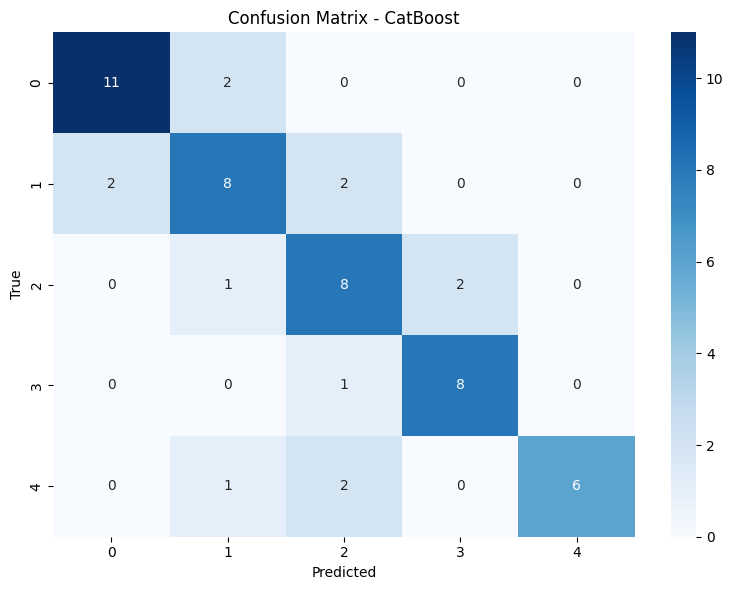


Accuracy: 0.7593
Weighted F1-Score: 0.7613


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification


# ==============================================================================
# PART 2: TRAIN FINAL MODEL WITH OPTIMAL WEIGHTS
# ==============================================================================
print("\nTraining final model with optimal weights...")
# User-provided class weights
best_weights = {0: 1.0, 1: 1.0, 2: 3.0, 3: 2.0, 4: 1.0}

# Get sample weights for the training run
final_sample_weights = np.array([best_weights[y] for y in y_train_resampled])

# Train the final CatBoost model
catboost_model = CatBoostClassifier(
    random_state=42,
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0
)
catboost_model.fit(X_train_resampled, y_train_resampled, sample_weight=final_sample_weights)

# ==============================================================================
# PART 3: EVALUATION
# ==============================================================================
print("\n" + "="*50)
print("CATBOOST CLASSIFICATION REPORT (with Optimal Weights)")
print("="*50)

# Predict
y_pred_catboost = catboost_model.predict(X_test_scaled)

# Evaluation
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_catboost, zero_division=0))

# Confusion Matrix
cm_catboost = confusion_matrix(y_test, y_pred_catboost)
print("CONFUSION MATRIX:")
print(cm_catboost)

# ==============================================================================
# PART 4: VISUALIZE THE RESULTS
# ==============================================================================
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CatBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Accuracy and F1 Scores
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_catboost):.4f}")
print(f"Weighted F1-Score: {f1_score(y_test, y_pred_catboost, average='weighted', zero_division=0):.4f}")

## RandomForest + Catboost stacking

Training the first-stage model: RandomForestClassifier...
Training the second-stage model: CatBoostClassifier (with RF predictions as features)...

TWO-STAGE HYBRID MODEL EVALUATION (DEFAULT THRESHOLD)
CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83        13
         1.0       0.57      0.67      0.62        12
         2.0       0.64      0.64      0.64        11
         3.0       0.73      0.89      0.80         9
         4.0       0.86      0.67      0.75         9

    accuracy                           0.72        54
   macro avg       0.74      0.73      0.73        54
weighted avg       0.74      0.72      0.73        54

CONFUSION MATRIX:
[[10  2  1  0  0]
 [ 1  8  1  1  1]
 [ 0  2  7  2  0]
 [ 0  1  0  8  0]
 [ 0  1  2  0  6]]

TWO-STAGE HYBRID MODEL EVALUATION (CUSTOM THRESHOLD)
CLASSIFICATION REPORT (Custom Threshold)
              precision    recall  f1-score   support

         0.0       0.91     

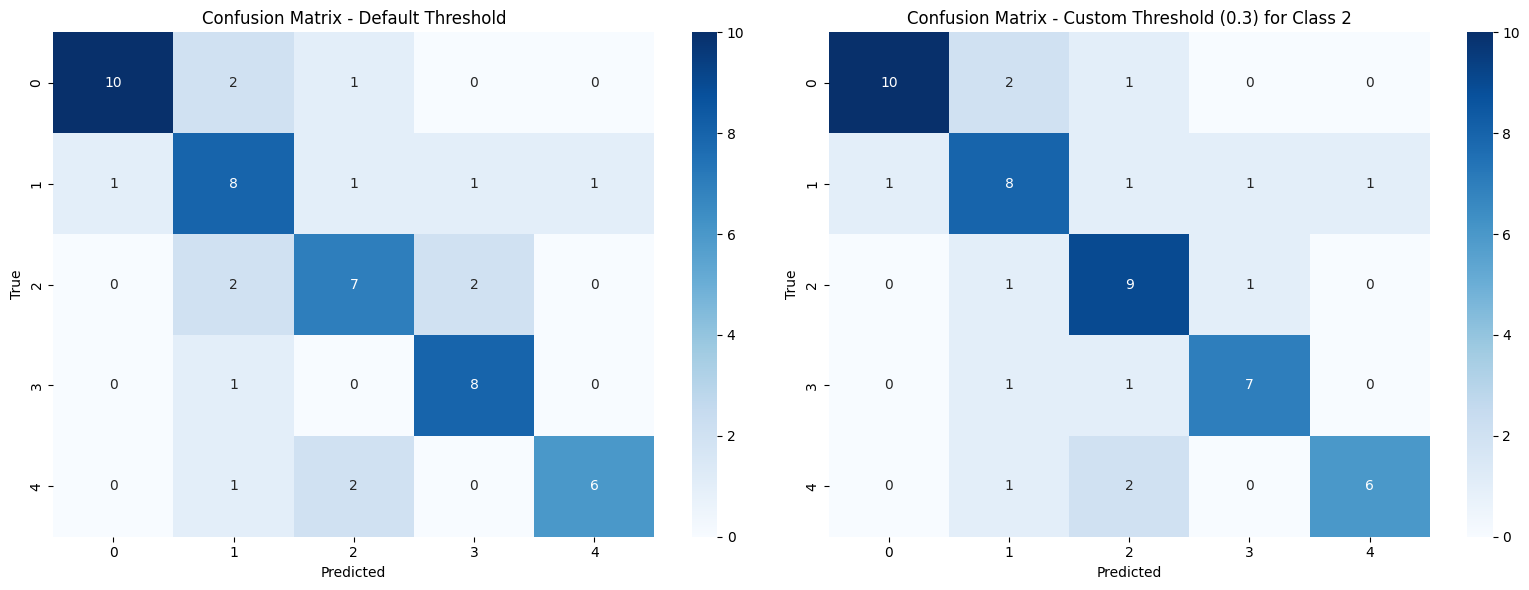


Accuracy (Default Threshold): 0.7222
Accuracy (Custom Threshold): 0.7407


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==============================================================================
# PART 1: TRAIN THE FIRST-STAGE MODEL (RANDOM FOREST)
# ==============================================================================
print("Training the first-stage model: RandomForestClassifier...")

# Define and train a RandomForestClassifier.
random_forest_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Use balanced class weights
)
random_forest_model.fit(X_train_resampled, y_train_resampled)

# Get the predicted probabilities from the Random Forest model for both
# the training and test sets. These will be our new "meta-features".
rf_train_preds = random_forest_model.predict_proba(X_train_resampled)
rf_test_preds = random_forest_model.predict_proba(X_test_scaled)

# ==============================================================================
# PART 2: TRAIN THE SECOND-STAGE MODEL (CATBOOST)
# ==============================================================================
print("Training the second-stage model: CatBoostClassifier (with RF predictions as features)...")

# Combine the original features with the new meta-features (RF probabilities).
X_train_hybrid = np.hstack((X_train_resampled, rf_train_preds))
X_test_hybrid = np.hstack((X_test_scaled, rf_test_preds))

# Define CatBoost model with class weights, just like your original code.
class_weights = {0: 1.0, 1: 1.5, 2: 2.5, 3: 2.5, 4: 1.5}
sample_weights = np.array([class_weights[y] for y in y_train_resampled])
catboost_model = CatBoostClassifier(
    random_state=42,
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0
)

# Train the CatBoost model on the combined feature set.
catboost_model.fit(X_train_hybrid, y_train_resampled, sample_weight=sample_weights)

# ==============================================================================
# PART 3: EVALUATION WITH DEFAULT THRESHOLD
# ==============================================================================
print("\n" + "="*50)
print("TWO-STAGE HYBRID MODEL EVALUATION (DEFAULT THRESHOLD)")
print("="*50)

# Predict on the test set using the second-stage CatBoost model.
y_pred_default = catboost_model.predict(X_test_hybrid)

# Classification Report
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_default, zero_division=0))

# Confusion Matrix
cm_default = confusion_matrix(y_test, y_pred_default)
print("CONFUSION MATRIX:")
print(cm_default)

# ==============================================================================
# PART 4: EVALUATION WITH CUSTOM THRESHOLD
# ==============================================================================
print("\n" + "="*50)
print("TWO-STAGE HYBRID MODEL EVALUATION (CUSTOM THRESHOLD)")
print("="*50)

# Get the predicted probabilities for each class on the test set.
y_probs_hybrid = catboost_model.predict_proba(X_test_hybrid)

# Define the target class and the custom threshold to improve its recall.
TARGET_CLASS = 2
CUSTOM_THRESHOLD = 0.3

# Initialize the custom predictions with the default predictions.
y_pred_custom = np.copy(y_pred_default)

# Get the probability scores for the target class.
target_class_probs = y_probs_hybrid[:, TARGET_CLASS]

# Find indices where the model's prediction is NOT the target class, but the
# probability for the target class is above our custom threshold.
indices_to_flip = np.where(
    (y_pred_default.flatten() != TARGET_CLASS) & (target_class_probs >= CUSTOM_THRESHOLD)
)[0]

# Now, update the custom prediction array at these indices.
y_pred_custom[indices_to_flip] = TARGET_CLASS

# Classification Report with custom predictions
print("CLASSIFICATION REPORT (Custom Threshold)")
print(classification_report(y_test, y_pred_custom, zero_division=0))

# Confusion Matrix with custom predictions
cm_custom = confusion_matrix(y_test, y_pred_custom)
print("CONFUSION MATRIX (Custom Threshold):")
print(cm_custom)

# ==============================================================================
# PART 5: VISUALIZE THE RESULTS
# ==============================================================================
# Plotting both confusion matrices for comparison
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Default Threshold')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Custom Threshold ({CUSTOM_THRESHOLD}) for Class {TARGET_CLASS}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Accuracy Scores
print(f"\nAccuracy (Default Threshold): {accuracy_score(y_test, y_pred_default):.4f}")
print(f"Accuracy (Custom Threshold): {accuracy_score(y_test, y_pred_custom):.4f}")

## SVM + Catboost Stacking + Thresholding

Training the first-stage model: SVC...
Training the second-stage model: CatBoostClassifier (with SVM predictions as features)...

TWO-STAGE HYBRID MODEL EVALUATION WITH CUSTOM THRESHOLDING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72        13
         1.0       0.62      0.67      0.64        12
         2.0       0.69      0.82      0.75        11
         3.0       0.89      0.89      0.89         9
         4.0       0.86      0.67      0.75         9

    accuracy                           0.74        54
   macro avg       0.76      0.75      0.75        54
weighted avg       0.75      0.74      0.74        54

CONFUSION MATRIX:
[[9 4 0 0 0]
 [2 8 1 1 0]
 [0 1 9 0 1]
 [0 0 1 8 0]
 [1 0 2 0 6]]


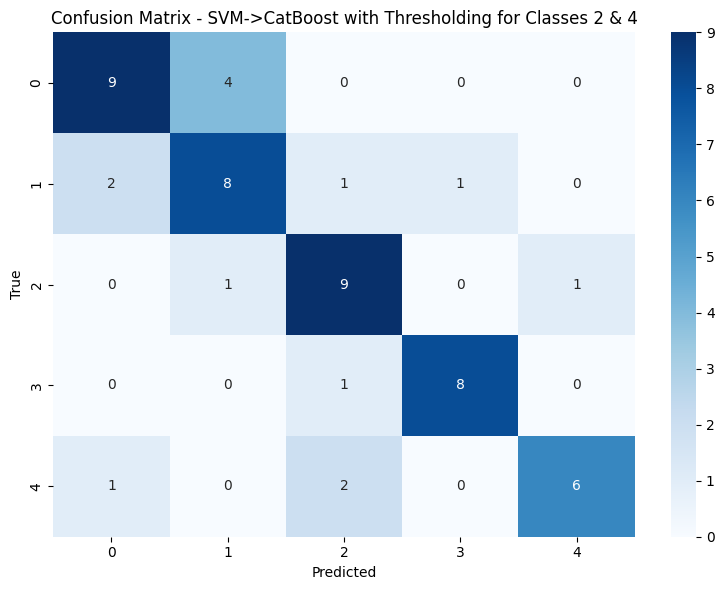


Accuracy: 0.7407


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

# NOTE: For this code to run, you must first have defined and populated
# X_train_resampled, y_train_resampled, X_test_scaled, y_test, and X_test_hybrid.
# This code block assumes these variables are already available from a prior context.

# ==============================================================================
# PART 1: TRAIN THE FIRST-STAGE MODEL (SVM)
# ==============================================================================
print("Training the first-stage model: SVC...")

# Define and train a Support Vector Classifier (SVC).
svm_model = SVC(
    random_state=42,
    kernel='rbf',
    class_weight='balanced',
    probability=True
)
svm_model.fit(X_train_resampled, y_train_resampled)

# Get the predicted probabilities from the SVM model for both
# the training and test sets.
rf_train_preds = svm_model.predict_proba(X_train_resampled)
rf_test_preds = svm_model.predict_proba(X_test_scaled)

# ==============================================================================
# PART 2: TRAIN THE SECOND-STAGE MODEL (CATBOOST)
# ==============================================================================
print("Training the second-stage model: CatBoostClassifier (with SVM predictions as features)...")

X_train_hybrid = np.hstack((X_train_resampled, rf_train_preds))
X_test_hybrid = np.hstack((X_test_scaled, rf_test_preds))

catboost_model = CatBoostClassifier(
    random_state=42,
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0
)

catboost_model.fit(X_train_hybrid, y_train_resampled)

# ==============================================================================
# PART 3: EVALUATION WITH PROBABILITY THRESHOLDING
# ==============================================================================
print("\n" + "="*50)
print("TWO-STAGE HYBRID MODEL EVALUATION WITH CUSTOM THRESHOLDING")
print("="*50)

# Get the predicted probabilities from the CatBoost model for the test set.
# The shape of y_pred_proba is (number_of_samples, number_of_classes)
y_pred_proba = catboost_model.predict_proba(X_test_hybrid)

# Get the default predictions from CatBoost.
y_pred_default = catboost_model.predict(X_test_hybrid)

# Create a copy to modify for thresholding.
y_pred_thresholded = y_pred_default.copy()

# Apply the custom thresholding for class 2 (0.3)
high_prob_class_2_indices = y_pred_proba[:, 2] > 0.3
y_pred_thresholded[high_prob_class_2_indices] = 2

# Apply the custom thresholding for class 4 (0.2)
high_prob_class_4_indices = y_pred_proba[:, 4] > 0.9
y_pred_thresholded[high_prob_class_4_indices] = 4

# Classification Report
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_thresholded, zero_division=0))

# Confusion Matrix
cm_thresholded = confusion_matrix(y_test, y_pred_thresholded)
print("CONFUSION MATRIX:")
print(cm_thresholded)

# ==============================================================================
# PART 4: VISUALIZE THE RESULTS
# ==============================================================================
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_thresholded, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM->CatBoost with Thresholding for Classes 2 & 4')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Accuracy Score
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_thresholded):.4f}")